## Real-world Splitgraph benchmarks

This notebook contains various benchmarks with real data hosted on Splitgraph Cloud.

Note that running this will require about 5 GiB of free disk space.

In [1]:
import itertools
import random

import pandas as pd
import seaborn as sns

from splitgraph.core.repository import Repository, clone
from splitgraph.core.common import Tracer, pretty_size
from splitgraph.engine import ResultShape
from splitgraph.core.engine import lookup_repository

from psycopg2.sql import SQL, Identifier

import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (10,10)

import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.WARNING)

In [2]:
dataset_queries = {
    # Geonames dump from http://download.geonames.org/export/dump/allCountries.zip
    "splitgraph/geonames": """SELECT * FROM all_countries WHERE asciiname = 'Cambridge' 
       AND feature_class = 'P' AND country_code = 'GB'""",
    # https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LYWX3D
    "splitgraph/2016_election": """SELECT candidate_normalized, SUM(votes) FROM precinct_results 
        WHERE state_postal = 'TX' GROUP BY candidate_normalized""",
    # http://academictorrents.com/details/a2ccf94bbb4af222bf8e69dad60a68a29f310d9a/tech
    "splitgraph/domestic_us_flights": """SELECT fly_month, origin_airport, SUM(passengers) AS total_passengers FROM flights 
        WHERE fly_month >= '2008-01-01' AND fly_month < '2009-01-01' 
        GROUP BY fly_month, origin_airport""",
    # US Congress tweets from https://raw.githubusercontent.com/alexlitel/congresstweets/master/data/
    "splitgraph/congress_tweets": "SELECT screen_name, COUNT(1) FROM tweets WHERE time > '2020-01-01' GROUP BY screen_name"
}

Grab some quick metadata about these datasets from the registry before we clone them.

In [3]:
repo_metadata = []
for dataset in dataset_queries:
    repo = lookup_repository(dataset)
    latest = repo.images["latest"]
    size = latest.get_size()
    table = latest.get_tables()[0]
    table_len = latest.get_table(table).get_length()
    
    repo_metadata.append((str(repo), table, pretty_size(size), table_len))

In [4]:
repo_df = pd.DataFrame(repo_metadata, columns=["Name", "Table", "Total size", "Number of rows"])
repo_df

,Name,Table,Total size,Number of rows
0,splitgraph/geonames,all_countries,539.95 MiB,11968169
1,splitgraph/2016_election,precinct_results,26.75 MiB,1989234
2,splitgraph/domestic_us_flights,flights,59.17 MiB,3606803
3,splitgraph/congress_tweets,tweets,439.24 MiB,2254156


In [5]:
for dataset in dataset_queries:
    clone(dataset, single_image="latest", download_all=True)

100%|██████████| 1/1 [00:02<00:00,  2.45s/obj, object=ob4772e9a2...]


We'll run the following tests for these datasets:

  * Run a sample query for each using layered querying
  * Check them out into a real PostgreSQL schema
  * Run the same sample query again
  * Compare the size taken up by the dataset in Splitgraph vs. PostgreSQL table.

In [6]:
test_results = []
for dataset, query in dataset_queries.items():
    print(f"Testing {dataset}")
    repo = Repository.from_schema(dataset)
    latest = repo.images["latest"]
    sg_size = latest.get_size()
    table = latest.get_tables()[0]
    
    iterations = 20
    
    print(f"Running LQ...")
    # Run the sample query via LQ
    with latest.query_schema() as s:
        # Run the query once for warmup
        repo.object_engine.run_sql_in(s, query)
        tracer = Tracer()
        for _ in range(iterations):
            repo.object_engine.run_sql_in(s, query)
        tracer.log("run_lq")
    print(f"Checking out {dataset}...")
    
    repo.rollback_engines()
    
    # Check the dataset out
    latest.checkout()
    
    # Get the table size in PG
    pg_size = repo.object_engine.run_sql("SELECT pg_total_relation_size(%s)",
                          ('"' + repo.to_schema() + '".' + table,),
                          return_shape=ResultShape.ONE_ONE)
    
    # Run the query against PG directly
    print(f"Running query on PG...")
    # Run once for warmup.
    repo.run_sql(query)
    tracer.log("checkout")
    for _ in range(iterations):
        repo.run_sql(query)

    tracer.log("run_pg")
    
    events = dict(tracer.get_durations())
    test_results.append({"Dataset": dataset, "Query": query, 
                         "Size in Splitgraph": sg_size, "Size in PostgreSQL": pg_size, 
                         "Query time (LQ)": events["run_lq"] / iterations,
                         "Query time (PG)": events["run_pg"] / iterations
                        })
    
    repo.uncheckout(force=True)
    repo.rollback_engines()


Testing splitgraph/geonames
Running LQ...
Checking out splitgraph/geonames...


100%|██████████| 120/120 [13:55<00:00,  6.97s/obj, object=o357b469f4...]


Running query on PG...
Testing splitgraph/2016_election
Running LQ...
Checking out splitgraph/2016_election...


100%|██████████| 20/20 [00:42<00:00,  2.13s/obj, object=o974b20261...]


Running query on PG...
Testing splitgraph/domestic_us_flights
Running LQ...
Checking out splitgraph/domestic_us_flights...


100%|██████████| 73/73 [02:30<00:00,  2.07s/obj, object=oc5c37c5d2...]


Running query on PG...
Testing splitgraph/congress_tweets
Running LQ...
Checking out splitgraph/congress_tweets...


100%|██████████| 85/85 [01:10<00:00,  1.21obj/s, object=ob4772e9a2...]


Running query on PG...


In [7]:
test_results_df = pd.DataFrame(test_results)
test_results_df_pretty = test_results_df.copy()
test_results_df_pretty["Size in Splitgraph"] = test_results_df_pretty["Size in Splitgraph"].apply(pretty_size)
test_results_df_pretty["Size in PostgreSQL"] = test_results_df_pretty["Size in PostgreSQL"].apply(pretty_size)
test_results_df_pretty

,Dataset,Query,Size in Splitgraph,Size in PostgreSQL,Query time (LQ),Query time (PG)
0,splitgraph/geonames,SELECT * FROM all_countries WHERE asciiname = ...,539.95 MiB,2.07 GiB,0.763744,1.883223
1,splitgraph/2016_election,"SELECT candidate_normalized, SUM(votes) FROM p...",26.81 MiB,551.18 MiB,0.207554,0.304762
2,splitgraph/domestic_us_flights,"SELECT fly_month, origin_airport, SUM(passenge...",59.17 MiB,448.27 MiB,0.698373,0.622456
3,splitgraph/congress_tweets,"SELECT screen_name, COUNT(1) FROM tweets WHERE...",439.24 MiB,1.02 GiB,0.329205,0.407519


Text(0.5, 1.0, 'Sample query performance on real-world datasets')

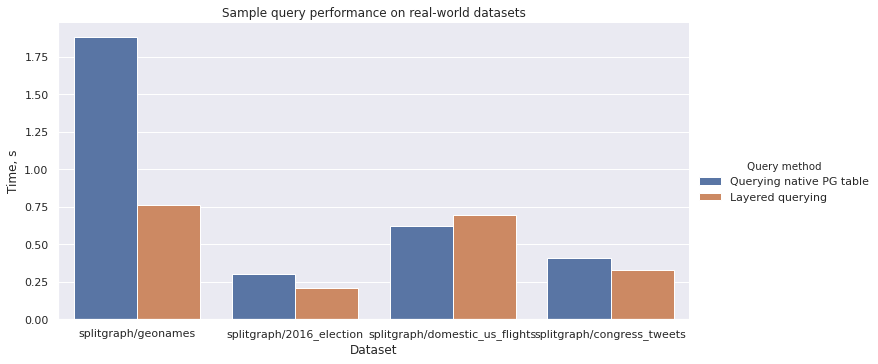

In [8]:
# Plot the results
query_time_df = test_results_df[["Dataset", "Query time (PG)", "Query time (LQ)"]]
query_time_df.columns = ["Dataset", "Querying native PG table", "Layered querying"]

query_time_df = pd.melt(query_time_df, id_vars="Dataset", var_name="Query method", value_name="Time, s")
sns.catplot(data=query_time_df, x="Dataset", y="Time, s", hue="Query method", kind="bar", height=5, aspect=2)
plt.yscale("linear")
plt.title("Sample query performance on real-world datasets")

Text(0.5, 1.0, 'Sample storage costs of real-world datasets')

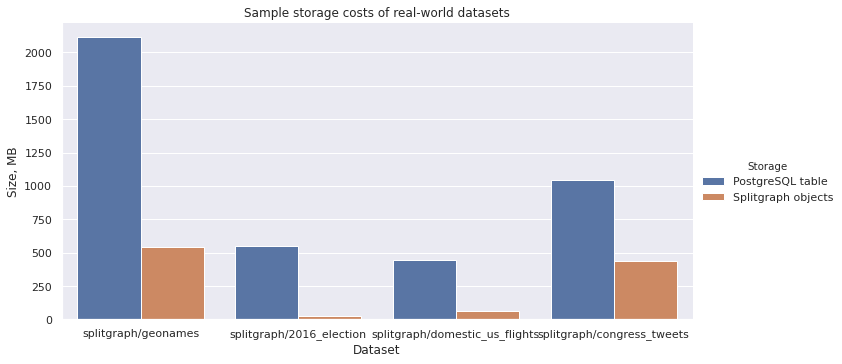

In [9]:
size_df = pd.DataFrame()
size_df["Dataset"] = test_results_df["Dataset"]
size_df["PostgreSQL table"] = test_results_df["Size in PostgreSQL"] / 1024. / 1024.
size_df["Splitgraph objects"] = test_results_df["Size in Splitgraph"] / 1024. / 1024.

size_df = pd.melt(size_df, id_vars="Dataset", var_name="Storage", value_name="Size, MB")
sns.catplot(data=size_df, x="Dataset", y="Size, MB", hue="Storage", kind="bar", height=5, aspect=2)
plt.yscale("linear")
plt.title("Sample storage costs of real-world datasets")

On real-world datasets, Splitgraph's layered querying can sometimes beat PostgreSQL's performance. This is usually due to two reasons:

  * Splitgraph has its own high-level indexing that allows it to not scan through fragments that aren't pertinent to the query. Layered querying cheats a bit here, since the PostgreSQL tables in this benchmark don't have any indexes at all (apart for the primary key constraint), but indexes used by Splitgraph are tiny (at most a hundred kilobytes per fragment) compared to PostgreSQL.
  * For its object storage backend, Splitgraph uses [`cstore_fdw`](https://github.com/citusdata/cstore_fdw), a columnar datastore extension for PostgreSQL. Especially in real-world datasets where a lot of columns have long runs of similar or same values, this results in data stored in Splitgraph being much smaller than when it's checked out into a PostgreSQL table. With less data to process, full table scans can be faster in `cstore_fdw` and have less IO load than full scans through PostgreSQL tables.
    * As an example, the `splitgraph/2016_election` dataset is about 20x smaller when stored as Splitgraph objects than when it's checked out. This is because it's a very wide dataset (36 columns) with a lot of values being the same (empty or with zeros). PostgreSQL tuples still need to allocate some space to those values, whereas in `cstore_fdw` files these columns can get compressed to much smaller sizes.

The best performance for a single kind of query is always going to be achieved with a PostgreSQL table and specially tuned indexes. However, layered querying is perfect for exploratory and analytical workloads, given its good-enough performance even for queries that require full table scans and the ability to lazily query a huge remote dataset by only downloading a few fragments and without checking the dataset out.